# Optimal complexity finite element assembly

## Sum factorisation
TSFC \[1\], the form compiler in Firedrake, generates the local assembly kernels from the weak forms of the PDEs, applying optimisations during the process to reduce the number of floating-point operations (FLOPs) required for the assembly computation. For *tensor product elements*, TSFC is capable of exploiting the intrinsic structure of the finite element, provided by FInAT \[2\], and apply *sum factorisation* to generate kernels with optimal algorithmic complexity.

Consider a hexahedral element, which is a 3D tensor product element created by the product of 1D intervals. Each quadrature point $X$ can be represented as a 3-tuple $q=\{q_1,q_2,q_3\}$, and each basis function by a 3-tuple $i = \{i_1,i_2,i_3\}$. Thus the naive local assembly kernel for the local tensor $A_{ij}$ contains the loop structure:
```
for q1, q2, q3
  for i1, i2, i3
    for j1, j2, j3
      A[i1,i2,i3,j1,j2,j3] += ...
```
This requires $O(N_{q}^3N_{j}^6)$ FLOPs. For polynomial degree $n$, both $N_q$ and $N_j$ are $O(n)$, so this local assembly requires $O(n^9)$ FLOPs.

But here we can rewrite the tabulation of the basis functions as tensor products of the tabulation tensors of the component elements:
\begin{aligned}
\Phi_{iq} &\equiv \Phi^1_{i_1q_1}\Phi^2_{i_2q_2}\Phi^3_{i_3q_3} \\
and\quad D\Phi_{iq} &\equiv D\Phi^1_{i_1q_1}\Phi^2_{i_2q_2}\Phi^3_{i_3q_3},
\end{aligned}
so that loop-invariant computation can be hoisted out of the innermost loop into temporary variables:
```
for q1, i1, j1
  t1 = ...
    for q2, i2, j2
      t2 = ...
        for q3, i3, j3
          A[i1,i2,i3,j1,j2,j3] += t1*t2*...
```
This reduces the complexity to $O(n^7)$.

TSFC organises the optimisation passes into *modes*. The default mode is *spectral*, which applies sum factorisation to determine the tensor contraction order, and at each level, apply *argument factorisation* to rearrange the expression using associative and distributive laws. The modes can be selected by setting parameters. As an example, we look at the assembly of Laplace operator on a hexahedral mesh.

In [1]:
from firedrake import *

We can create a hexahedral mesh by extruding a quadrilateral.

In [2]:
mesh = ExtrudedMesh(UnitSquareMesh(10, 10, quadrilateral=True), 10)

Let's choose the continuous Lagrange element of degree 5 as our function space.

In [20]:
n = 5
V = FunctionSpace(mesh, "CG", n)
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) *dx  # Laplace operator

Firedrake internalise the process of local assembly, to look at the kernel, we need to import the compilation function from TSFC.

In [4]:
from tsfc import compile_form

Let's first try the *vanilla* mode, which does as little optimisation as possible

In [14]:
kernel_vanilla, = compile_form(a, parameters={"mode": "vanilla"})

The COFFEE package provides some useful tools to inspect the local assembly kernel, such as the FLOPs estimator.

In [16]:
from coffee.visitors import EstimateFlops
print("Local assembly FLOPs with vanilla mode is {0:.3g}".format(EstimateFlops().visit(kernel_vanilla.ast)))

Local assembly FLOPs with vanilla mode is 7.22e+07


Now we do the same but with the *spectral* mode, which is the default mode in TSFC and implements sum factorisation.

In [17]:
kernel_spectral, = compile_form(a, parameters={"mode": "spectral"})
print("Local assembly FLOPs with spectral mode is {0:.3g}".format(EstimateFlops().visit(kernel_spectral.ast)))

Local assembly FLOPs with spectral mode is 2.13e+06


This is a 34x reduction in FLOPs. Not too bad, but there's opportunity to do better. For spectral elements, if we use the Gauss–Lobatto–Legendre (GLL) quadrature scheme, which has quadrature points collated with the Lagrange basis function nodes, then we know that the basis function tabulation is an indentity matrix. TSFC and FInAT can further simplify the loop structure of the local assembly kernels. This reduces the complexity to $O(n^5)$

We need to specify the GLL quadrature scheme for hexahedra. We can do this with FIAT, which defines GLL on intervals, and FInAT, which makes the tensor product scheme from the interval scheme.

In [18]:
import FIAT, finat

def gauss_lobatto_legendre_line_rule(degree):
    fiat_make_rule = FIAT.quadrature.GaussLobattoLegendreQuadratureLineRule
    fiat_rule = fiat_make_rule(FIAT.ufc_simplex(1), degree + 1)
    finat_ps = finat.point_set.GaussLobattoLegendrePointSet
    finat_qr = finat.quadrature.QuadratureRule
    return finat_qr(finat_ps(fiat_rule.get_points()), fiat_rule.get_weights())

def gauss_lobatto_legendre_cube_rule(dimension, degree):
    make_tensor_rule = finat.quadrature.TensorProductQuadratureRule
    result = gauss_lobatto_legendre_line_rule(degree)
    for _ in range(1, dimension):
        line_rule = gauss_lobatto_legendre_line_rule(degree)
        result = make_tensor_rule([result, line_rule])
    return result

We start by creating the spectral finite element function space of the same polynomial degree.

In [59]:
element = FiniteElement('CG', mesh.ufl_cell(), degree=n, variant='spectral')  # CG or Q?
V = FunctionSpace(mesh, element)
u = TrialFunction(V)
v = TestFunction(V)

We need to tell Firedrake to use the GLL quadratures for numerical integration.

In [60]:
gll_quadrature_rule = gauss_lobatto_legendre_cube_rule(dimension=3, degree=n)
a_gll = dot(grad(u), grad(v)) *dx(rule=gll_quadrature_rule)

In [61]:
kernel_gll, = compile_form(a_gll, parameters={"mode": "spectral"})
print("Local assembly FLOPs with GLL quadrature is {0:.3g}".format(EstimateFlops().visit(kernel_gll.ast)))

UFL:WARNING Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.


Local assembly FLOPs with GLL quadrature is 2.21e+05


This is a further 10x reduction in FLOPs.

Finally, let's verify that we achieve the expected asymptotic algorithmic complexity with respect to polynomial degrees.

In [105]:
from collections import defaultdict

flops = defaultdict(list)
ns = range(1, 33)
modes = {
    'gll': {'mode': 'spectral', 'variant': 'spectral', 'rule': gauss_lobatto_legendre_cube_rule},
    'spectral': {'mode': 'spectral', 'variant': None, 'rule': lambda *args: None},
    'vanilla': {'mode': 'vanilla', 'variant': None, 'rule': lambda *args: None}
}

for n in ns:
    for mode in modes:
        element = FiniteElement('CG', mesh.ufl_cell(), degree=n, variant=modes[mode]['variant'])
        V = FunctionSpace(mesh, element)
        u = TrialFunction(V)
        v = TestFunction(V)
        a = dot(grad(u), grad(v))*dx(rule=modes[mode]['rule'](3, n))
        kernel, = compile_form(a, parameters={"mode": modes[mode]['mode']})
        flops[mode].append(EstimateFlops().visit(kernel.ast))

UFL:WARNING Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
UFL:WARNING Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
UFL:WARNING Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
UFL:WARNING Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
UFL:WARNING Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
UFL:WARNING Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
UFL:WARNING Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
UFL:WARNING Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
UFL:WARNING Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this i

<IPython.core.display.Javascript object>


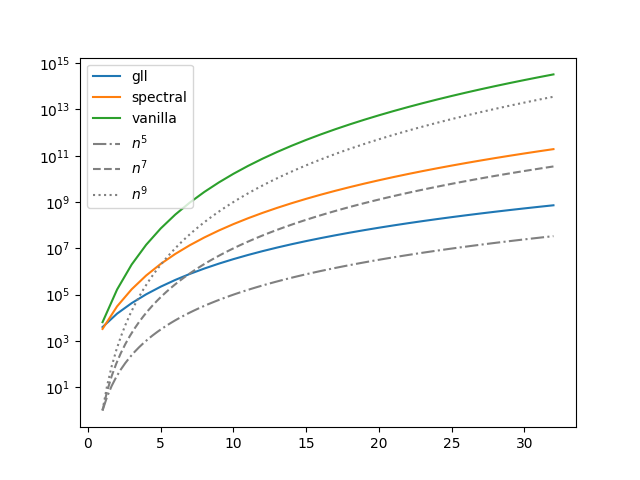

In [106]:
%matplotlib notebook
import numpy
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
# ax.set_xscale('log')
ax.set_yscale('log')
for mode in modes:
    ax.plot(ns, flops[mode], label=mode)
x = numpy.linspace(1, 32, 100)
for p, style in zip([5,7,9], ['-.','--',':']):
    ax.plot(x, numpy.power(x, p), label=r"$n^{0}$".format(p), color='grey', linestyle=style)
ax.legend(loc='upper left');

## More to come ... 

### automated SIMD vectorisation with loo.py

SIMD vectorisation achieves significant fraction of peak performance on Intel Skylake Xeon with AVX512 instructions
![simd](image/skylake-simd.png)

## References
\[1\] Homolya, M., Mitchell, L., Luporini, F. and Ham, D.A., 2018. TSFC: a structure-preserving form compiler. SIAM Journal on Scientific Computing, 40(3), pp.C401-C428.

\[2\] Homolya, M., Kirby, R.C. and Ham, D.A., 2017. Exposing and exploiting structure: optimal code generation for high-order finite element methods. arXiv preprint arXiv:1711.02473.


## Argument factorisation

Apart from tensor contractions, TSFC also has optimisation passes that rewrites the expression based on associativity and distributivity, called argument factorisation. Argument factorisation takes advantage of the linearity of the differential form with respect to its arguments to create invariant loop-invariant expressions and reduces the FLOPs in the innermost loops.

Consider the simple expression $ a_{ij} = b_id_j + c_id_j $, the naive nested loop to compute $ a_{ij} $ is
```
for i
  for j
    a[i,j] = b[i]*d[j] + c[i]d[j]
```
However, we can rewrite the expression as $ a_{ij} = (b_i+c_i)d_j$, and the subexpression $b_i+c_i$ is invariant to index $j$, which can be hoisted into a temporary:
```
for i
  t = b[i] + c[j]
  for j
    a[i,j] = t*d[j]
```
Usually, there are multiple ways to rewrite the expression, which might require expansion using the distributive rule. TSFC solves a Interger Linear Programming model to choose the transformation. More details and compilicated examples can be found at the paper \[2\]